# RV CURVE RMS COMPARISON

In this notebook we compare the signal RMS distributions between two samples composed of different RV time series.

The idea is to see if both signal RMS distributions are similar to each other. This is intended as part of the proof that the synthetic dataset created has the same statistical characteristic as the original CARMENES ML subsample of RV curves.

This notebook takes two different folders as input, calculates the set of signal RMS values for each of the curves in each folder, and then compares the histrogram and distributions of both samples.

It also stores the results of the RMS for each individual file in a table, in the folder for source data.

## Modules and configuration

### Modules

In [139]:
import os
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, normaltest

#from distfit import distfit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [140]:
# Files and folders specification:
FOLDER_A = "../data/ML_RVs/" # Only the RV curves used for the ML approach (i.e. those with RMS < 5 m/s)
FILE_ENDING_A = ".avc.dat" # Ending pattern for file selection.
COL_INDEX_A = 1 # Column index where the signal values are located (zero-based)
COL_INDEX_A1 = 2 # Column index where the error values are located (zero-based)
SEP_A = ' ' # Column separator

FOLDER_B = "../data/RV_DATASETS/S4_ts_files/"
FILE_ENDING_B = ".dat" # Ending pattern for file selection.
COL_INDEX_B = 1 # Column index where the signal values are located (zero-based)
COL_INDEX_B1 = 2 # Column index where the error values are located (zero-based)
SEP_B = ' ' # Column separator

OUT_IMG_FOLDER = "./img/"

# STATISTICAL CONSTANTS:
#SIGMAS = 3.0 # Number of sigmas above which to discard outliers.
#LOW_PC = 1.0 # Lower percentile (%) to discard possible outliers by percentile method.
#HIGH_PC = 99.0 # Higher percentile (%) to discard possible outliers by percentile method.
ALPHA = 1e-3 # Significance threshold for statistical tests
DISCARD_PERCENTILE = 95 # Percentile (in %) to discard high RMS values from A sample.

### Functions

In [141]:
def rms_calc(folder, pattern, sep, col, sample_id=""):
    '''Calculates the RMS in a series of files and return the list of values'''
    files = os.listdir(folder)
    rms_results = pd.DataFrame(columns=['file', 'rms'])
    error_files = []
    for file in files:
        if file[-len(pattern):] == pattern:
            #if True: # TEST
            try:
                signal_df = pd.read_csv(folder + file, sep=sep, decimal=".")
                values = signal_df.iloc[:, col]
                rms_file = np.sqrt(((values - values.mean()) ** 2).mean())
                new_row = pd.DataFrame({'file': [file], 'rms': [rms_file]})
                rms_results = pd.concat([rms_results, new_row], axis=0 , ignore_index=True)
            #else: # TEST
            except Exception as e:
                error_files.append((file, "Error: " + str(e)))
                print("Unable to process file %s. Error: %s" %(file, str(e)))
        else:
            pass
    # Save the results
    rms_results.to_csv(folder + sample_id + "_RMS_values.csv", sep=',', decimal='.', index=False)
    return rms_results, error_files

In [142]:
def draw_hist(d1, d1_label, fig_filename=None):
    '''Draws an histogram of the values passed. It also calulates the statistics
    and tests the goodness of fit by a Gaussian distribution'''
    # Plots and saves the figure
    kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    plt.title(d1_label + " values distribution", fontsize=16)
    plt.grid(axis='x', alpha=0.75)
    plt.xlabel(d1_label, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    sns.distplot(d1, label=d1_label, **kwargs)
    #sns.histplot(d1, label=d1_label)
    #plt.xlim(0,100)
    #plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Display basic statistics:
    print(pd.Series(d1).describe())
    # Perform the normaltest (D'Agostino and Pearson) for Gaussian distribution fit:
    k2, p = normaltest(d1)
    alpha = ALPHA
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("***This distribution does NOT come from a Gaussian distribution" \
              "(with significance level = %.6f)" %(1.0 - alpha))
    else:
        print("This distribution MIGHT COME come from Gaussian distribution" \
              "(with significance level = %.6f)" %(1.0 - alpha))

In [143]:
def compare_dist(d1, d2, d1_label, d2_label, varname=None, fig_title=None, fig_filename=None, kde=False):
    '''Plots and saves overlapped histograms.
    It also shows the result of a t-Student test.'''
    # Plots and saves the figure
    kwargs = dict(hist_kws={'alpha': .9, 'histtype': 'step', 'linewidth': 2},
                  kde_kws={'linewidth': 2})
    plt.figure(figsize=(10,7))
    if fig_title is None:
        plt.title("Comparison of distributions", fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    plt.grid(axis='x', alpha=0.75)
    plt.ylabel('Frequency', fontsize=12)
    ax1 = sns.distplot(d1, label=d1_label, **kwargs)
    ax2 = sns.distplot(d2, label=d2_label, **kwargs)
    if varname is None:
        ax1.set_xlabel("%s / %s" %(d1_label, d2_label), fontsize=12)
    else:
        ax1.set_xlabel(varname, fontsize=12)
    #plt.xlim(0,100)
    plt.legend(loc='upper right');
    if kde == False:
        ax1.get_lines()[0].remove()
        ax2.get_lines()[0].remove()
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg')
    # Perform the t-Student test (as independent samples):
    print("t-Student test results:")
    stat, p = ttest_ind(d1, d2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('***Probably different distributions')


## Calculate RMS values of the RV values

### RV values RMS for sample A

In [144]:
a_results, a_errors = rms_calc(folder=FOLDER_A, pattern=FILE_ENDING_A, sep=' ', col=COL_INDEX_A,
                               sample_id="CARMENES_ML_subsample")

In [145]:
a_results.head()

,file,rms
0,J00051+457.avc.dat,2.834436
1,J00067-075.avc.dat,2.662173
2,J00162+198E.avc.dat,3.104818
3,J00183+440.avc.dat,3.006480
4,J00184+440.avc.dat,2.510060


In [146]:
print(a_errors)

[]


We now see the histogram:

count    233.000000
mean       3.364116
std        1.297120
min        0.621065
25%        2.508292
50%        3.102729
75%        3.966045
max       11.776074
Name: rms, dtype: float64
p = 4.07132e-30
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


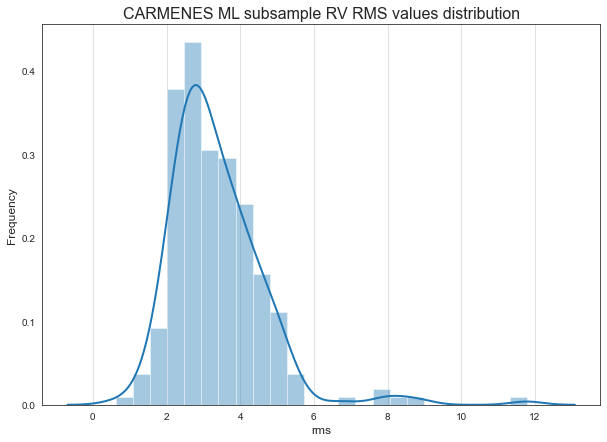

In [147]:
draw_hist(d1=a_results['rms'], d1_label="CARMENES ML subsample RV RMS")

We see that there are some extreme values here. We probably need to discard outliers.

In [148]:
a_threshold = np.percentile(a_results['rms'], q=DISCARD_PERCENTILE)
a_threshold

5.155830838865597

count    221.000000
mean       3.166892
std        0.896683
min        0.621065
25%        2.471529
50%        3.003283
75%        3.791832
max        5.124163
Name: rms, dtype: float64
p = 0.0718311
This distribution MIGHT COME come from Gaussian distribution(with significance level = 0.999000)


C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


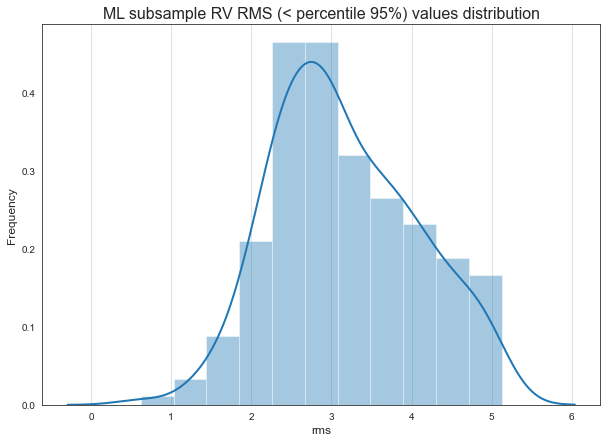

In [149]:
draw_hist(d1=a_results[a_results['rms'] < a_threshold]['rms'],
          d1_label="ML subsample RV RMS (< percentile %d%%)" %DISCARD_PERCENTILE)

### RV values RMS for sample B

In [150]:
b_results, b_errors = rms_calc(folder=FOLDER_B, pattern=FILE_ENDING_B, sep=' ', col=COL_INDEX_B,
                               sample_id="Synth_S4")

In [151]:
b_results.head()

,file,rms
0,S4-RV_Star-Star-00000.dat,1.724107
1,S4-RV_Star-Star-00001.dat,2.459898
2,S4-RV_Star-Star-00002.dat,2.600051
3,S4-RV_Star-Star-00003.dat,1.311091
4,S4-RV_Star-Star-00004.dat,2.244221


In [152]:
print(b_errors)

[]


We now see the histogram:

count    1000.000000
mean        1.878976
std         1.760159
min         0.224384
25%         1.410424
50%         1.646191
75%         1.976798
max        37.810935
Name: rms, dtype: float64
p = 0
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


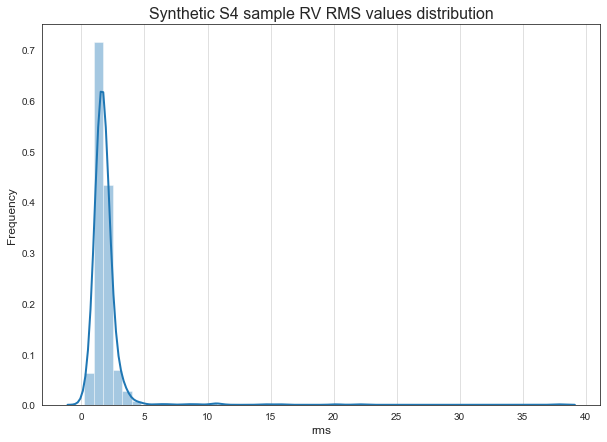

In [153]:
draw_hist(d1=b_results['rms'], d1_label="Synthetic S4 sample RV RMS")

Again, we see that there are some extreme values here. We probably need to discard outliers.

In [154]:
b_threshold = np.percentile(b_results['rms'], q=DISCARD_PERCENTILE)
b_threshold

3.0168829955171708

count    950.000000
mean       1.656159
std        0.441902
min        0.224384
25%        1.390445
50%        1.630059
75%        1.901790
max        3.016453
Name: rms, dtype: float64
p = 0.000278831
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


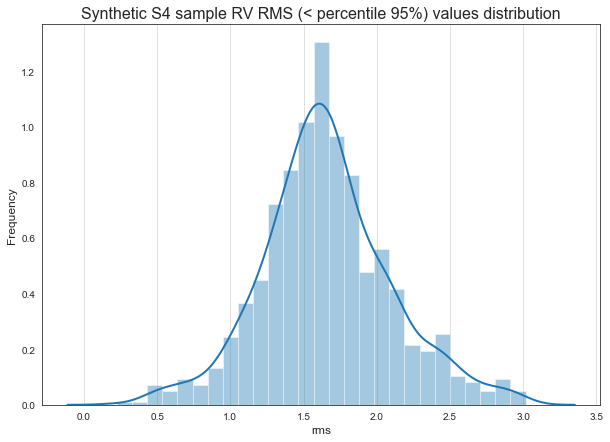

In [155]:
draw_hist(d1=b_results[b_results['rms'] < b_threshold]['rms'],
          d1_label="Synthetic S4 sample RV RMS (< percentile %d%%)" %DISCARD_PERCENTILE)

### RV values RMS distributions comparison

We now show the comparison of the RMS values of the real time series and the synthetic time series.

C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


t-Student test results:
stat=36.341, p=0.000
***Probably different distributions


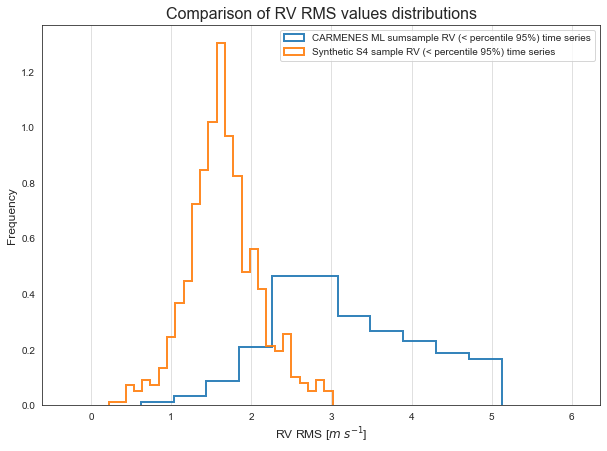

In [156]:
compare_dist(d1=a_results[a_results['rms'] <= a_threshold]['rms'],
             d2=b_results[b_results['rms'] <= b_threshold]['rms'],
             d1_label='CARMENES ML sumsample RV (< percentile %d%%) time series' %DISCARD_PERCENTILE,
             d2_label='Synthetic S4 sample RV (< percentile %d%%) time series' %DISCARD_PERCENTILE,
             varname='RV RMS [$m\;s^{-1}$]', fig_title="Comparison of RV RMS values distributions",
             fig_filename=OUT_IMG_FOLDER + \
                 "SyntheticDataset_31_01_RV_RMS_ML_subsample_pc%d_vs_Synth_S4.jpg" %DISCARD_PERCENTILE,
             kde=False)

**IMPORTANT OBSERVATION:** As we can see, both distributions look very different from each other. However, this is somehow expected, as the synthetic sample of stars was designed with a maximum pulsation amplitude of $1.5\;\rm{ms}^{-1}$.

## Calculate RMS values of the RV error

### RV error RMS for sample A

In [157]:
a1_results, a1_errors = rms_calc(folder=FOLDER_A, pattern=FILE_ENDING_A, sep=' ', col=COL_INDEX_A1,
                                 sample_id="CARMENES_ML_subsample")

In [158]:
a1_results.head()

,file,rms
0,J00051+457.avc.dat,0.682087
1,J00067-075.avc.dat,0.510899
2,J00162+198E.avc.dat,0.328388
3,J00183+440.avc.dat,0.527550
4,J00184+440.avc.dat,0.555233


In [159]:
print(a1_errors)

[]


We now see the histogram:

count    233.000000
mean       0.710730
std        0.903863
min        0.109279
25%        0.363804
50%        0.516816
75%        0.737897
max        8.297493
Name: rms, dtype: float64
p = 3.45214e-70
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


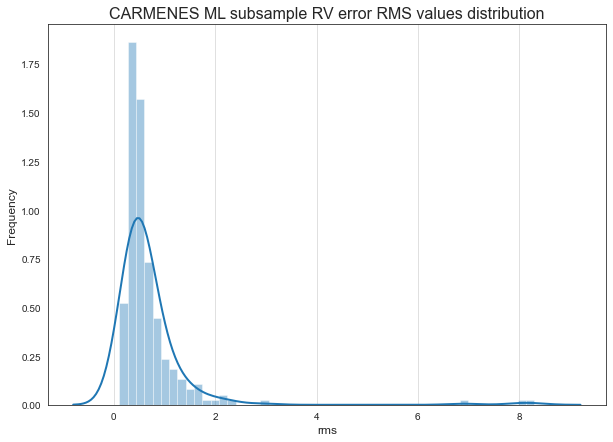

In [160]:
draw_hist(d1=a1_results['rms'], d1_label="CARMENES ML subsample RV error RMS")

We see that there are some extreme values here. We probably need to discard outliers.

In [161]:
a1_threshold = np.percentile(a1_results['rms'], q=DISCARD_PERCENTILE)
a1_threshold

1.6070879011724866

count    221.000000
mean       0.560968
std        0.289277
min        0.109279
25%        0.352468
50%        0.488357
75%        0.677692
max        1.588780
Name: rms, dtype: float64
p = 3.0422e-11
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


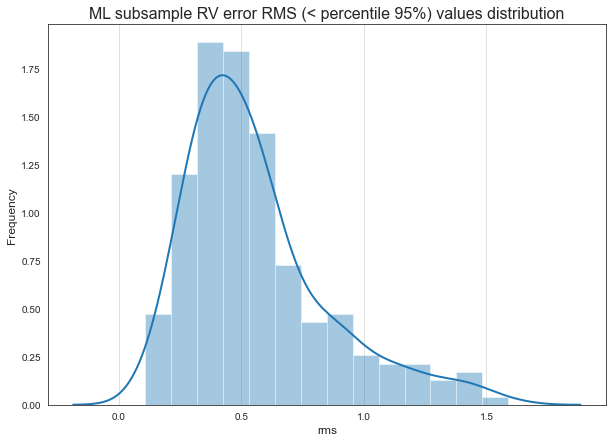

In [162]:
draw_hist(d1=a1_results[a1_results['rms'] < a1_threshold]['rms'],
          d1_label="ML subsample RV error RMS (< percentile %d%%)" %DISCARD_PERCENTILE)

### RV values RMS for sample B

In [163]:
b1_results, b1_errors = rms_calc(folder=FOLDER_B, pattern=FILE_ENDING_B, sep=' ', col=COL_INDEX_B1,
                               sample_id="Synth_S4")

In [164]:
b1_results.head()

,file,rms
0,S4-RV_Star-Star-00000.dat,0.321518
1,S4-RV_Star-Star-00001.dat,0.821286
2,S4-RV_Star-Star-00002.dat,0.572562
3,S4-RV_Star-Star-00003.dat,0.403509
4,S4-RV_Star-Star-00004.dat,0.671279


In [165]:
print(b1_errors)

[]


We now see the histogram:

count    1000.000000
mean        0.609811
std         1.019997
min         0.042643
25%         0.315270
50%         0.421791
75%         0.620891
max        17.098701
Name: rms, dtype: float64
p = 0
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


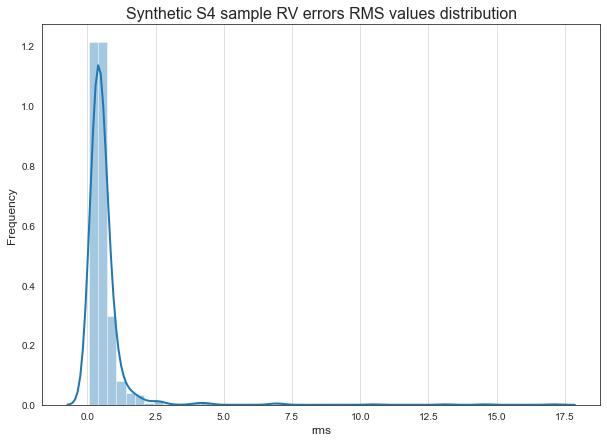

In [166]:
draw_hist(d1=b1_results['rms'], d1_label="Synthetic S4 sample RV errors RMS")

Again, we see that there are some extreme values here. We probably need to discard outliers.

In [167]:
b1_threshold = np.percentile(b1_results['rms'], q=DISCARD_PERCENTILE)
b1_threshold

1.2743540720945425

count    950.000000
mean       0.466149
std        0.232718
min        0.042643
25%        0.308978
50%        0.410730
75%        0.584528
max        1.272468
Name: rms, dtype: float64
p = 1.66789e-29
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


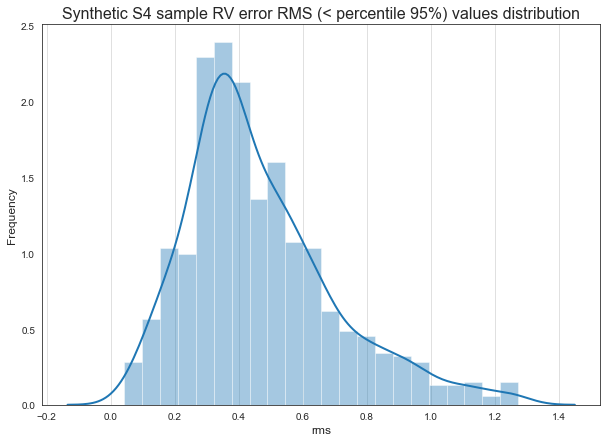

In [168]:
draw_hist(d1=b1_results[b1_results['rms'] < b1_threshold]['rms'],
          d1_label="Synthetic S4 sample RV error RMS (< percentile %d%%)" %DISCARD_PERCENTILE)

### RV values RMS distributions comparison

We now show the comparison of the RMS values of the real time series and the synthetic time series.

C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ciroe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


t-Student test results:
stat=5.196, p=0.000
***Probably different distributions


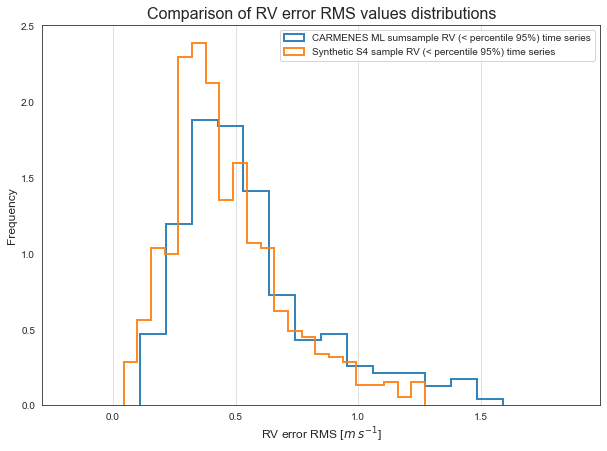

In [169]:
compare_dist(d1=a1_results[a1_results['rms'] <= a1_threshold]['rms'],
             d2=b1_results[b1_results['rms'] <= b1_threshold]['rms'],
             d1_label='CARMENES ML sumsample RV (< percentile %d%%) time series' %DISCARD_PERCENTILE,
             d2_label='Synthetic S4 sample RV (< percentile %d%%) time series' %DISCARD_PERCENTILE,
             varname='RV error RMS [$m\;s^{-1}$]', fig_title="Comparison of RV error RMS values distributions",
             fig_filename=OUT_IMG_FOLDER + \
                 "SyntheticDataset_31_02_RV_error_RMS_ML_subsample_pc%d_vs_Synth_S4.jpg" %DISCARD_PERCENTILE,
             kde=False)

**IMPORTANT OBSERVATION:** As we can see, we get the warning from the t-Student test saying that the two distributions are probably the same. However, the shape, location and peaks of both distributions are pretty similar to each other. It is true, though, that the RMS values of errors in the synthetic distribution seem to yield results lower that those for the real distribution. The difference is not that great, and we can go ahead with this synthetic noise, but **it would be interesting to know where this difference comes from**.